In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from google.colab import files
import matplotlib.pyplot as plt

# **Get The Kaggle Dataset**

[Dataset Link](https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset)

Get the Kaggle API KEY as mentioned in the [steps](https://www.kaggle.com/docs/api#authentication)

In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"<username>","key":"<api key>"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

# **Download The Dataset**

In [ ]:
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset

 99% 328M/330M [00:04<00:00, 98.9MB/s]
100% 330M/330M [00:04<00:00, 77.0MB/s]


**Unzip face-mask-12k-images-dataset.zip**

In [ ]:
!unzip 'face-mask-12k-images-dataset.zip' -d face_mask_image_dataset

Streaming output truncated to the last 5000 lines.
  inflating: face_mask_image_dataset/Face Mask Dataset/Train/WithoutMask/1855.png  
  inflating: face_mask_image_dataset/Face Mask Dataset/Train/WithoutMask/1856.png  
  inflating: face_mask_image_dataset/Face Mask Dataset/Train/WithoutMask/1857.png  
  inflating: face_mask_image_dataset/Face Mask Dataset/Train/WithoutMask/1858.png  
  inflating: face_mask_image_dataset/Face Mask Dataset/Train/WithoutMask/1859.png  
  inflating: face_mask_image_dataset/Face Mask Dataset/Train/WithoutMask/1860.png  
  inflating: face_mask_image_dataset/Face Mask Dataset/Train/WithoutMask/1861.png  
  inflating: face_mask_image_dataset/Face Mask Dataset/Train/WithoutMask/1862.png  
  inflating: face_mask_image_dataset/Face Mask Dataset/Train/WithoutMask/1863.png  
  inflating: face_mask_image_dataset/Face Mask Dataset/Train/WithoutMask/1864.png  
  inflating: face_mask_image_dataset/Face Mask Dataset/Train/WithoutMask/1865.png  
  inflating: face_mask_im

# **Preprocess And Analysis**

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

datagen = tf.keras.preprocessing.image.ImageDataGenerator( 
	rescale=1./255,
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# Use datagen object to preprocess the data
train_generator = datagen.flow_from_directory(
    "face_mask_image_dataset/Face Mask Dataset/Train",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE)

# I using the same object for preprocess data validation
val_generator = datagen.flow_from_directory(
    "face_mask_image_dataset/Face Mask Dataset/Validation",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


# **Create the MobileNetV2 CNN model**

**We are creating a CNN model using keras with input shape as (224,224,3) which stands for 35x35 RGB pictures . Refer [link](https://keras.io/api/layers/convolution_layers/convolution2d/)**

**A dropout layer has been added to prevent overfitting [link](https://keras.io/api/layers/regularization_layers/dropout/)**

In [ ]:
# As we have two classes withmask , without mask
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
dense = 2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')
model = base_model.output
model = AveragePooling2D(pool_size=(7, 7))(model)
model = Flatten(name="flatten")(model)
model = Dense(512, activation="relu")(model)
model = Dropout(0.5)(model)
model = Dense(128, activation="relu")(model)
model = Dropout(0.5)(model)
model = Dense(dense, activation="softmax")(model)

model = Model(inputs=base_model.input, outputs=model)

model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                               

# **Training The Keras Model**

**Prepare test train and validation images data by rescaling them and setting batch_size as 8 and epochs as 50**

A **batch size** is the number of training examples utilized in one iteration , you can rescale it as per your machine requirements

An **Epoch** is total number of iterations of all the training data in one cycle for training the machine learning model




In [ ]:
epochs = 10

checkpoint = ModelCheckpoint('model.{epoch:02d}-{val_loss:.2f}.h5',
                             monitor='val_loss',
                             verbose=0,
                             save_best_only=True,
                             mode='auto')

history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=epochs, 
                    validation_data=val_generator, 
                    validation_steps=len(val_generator),
                    callbacks=[checkpoint])

Epoch 1/10
157/157 [==============================] - 466s 3s/step - loss: 0.1402 - accuracy: 0.9467 - val_loss: 0.0415 - val_accuracy: 0.9825
Epoch 2/10
157/157 [==============================] - 482s 3s/step - loss: 0.0668 - accuracy: 0.9765 - val_loss: 0.0267 - val_accuracy: 0.9900
Epoch 3/10
157/157 [==============================] - 470s 3s/step - loss: 0.0538 - accuracy: 0.9815 - val_loss: 0.0208 - val_accuracy: 0.9937
Epoch 4/10
157/157 [==============================] - 458s 3s/step - loss: 0.0490 - accuracy: 0.9836 - val_loss: 0.0294 - val_accuracy: 0.9925
Epoch 5/10
157/157 [==============================] - 458s 3s/step - loss: 0.0458 - accuracy: 0.9835 - val_loss: 0.0244 - val_accuracy: 0.9887
Epoch 6/10
157/157 [==============================] - 462s 3s/step - loss: 0.0422 - accuracy: 0.9859 - val_loss: 0.0290 - val_accuracy: 0.9912
Epoch 7/10
157/157 [==============================] - 470s 3s/step - loss: 0.0391 - accuracy: 0.9863 - val_loss: 0.0162 - val_accuracy: 0.9950

# **Save The Model**

**Save The Model**

Refer the [docs](https://www.tensorflow.org/guide/keras/save_and_serialize) from the Tensorflow

In [ ]:
!mkdir '/content/model'
model.save('/content/model')

# **Learning Curves**

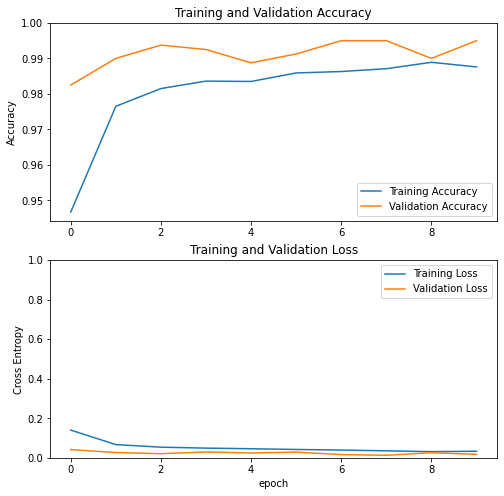

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# **Model To TFLITE**

**Using [Python API](https://www.tensorflow.org/lite/models/convert/convert_models) (Recommended Approach) we convert the Keras Model to TLITE** 

This TFLITE model will be deployed to our [Android App](https://github.com/generic-matrix/android-face-mask-detection) 

In [ ]:
!mkdir '/content/tflite'
saved_model_dir = '/content/model'
tflite_model_path = '/content/tflite/model.tflite'
# Convert the model
# path to the SavedModel directory
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) 
tflite_model = converter.convert()

# Save the model.
with open(tflite_model_path, 'wb') as f:
  f.write(tflite_model)

**Download The Files**

In [ ]:
# Download the tflite Model
files.download(tflite_model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>